In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it
import pickle
import os
import sympy as sp
from scipy.signal import peak_widths
from matplotlib import cm

import ccode.finite_system as tj
import ccode.tools as tl
import ccode.solvers as sl

import ccode.plotting as pt

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [3]:
a = 10e-9

In [4]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/trijunction_design/"  # Make sure to do this if you import any local modules!

# Triangular geometry with wires at one side

## Set up parameters

In [17]:
area = 800*a**2
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'down',
    "shape": 'triangle',
    "A": area
}

In [18]:
n_geometries = 50
angles = np.linspace(0.05, 0.3, n_geometries)

In [19]:
mus_qd = np.linspace(-0.002, 0.002, 200)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/triangle_angles_one_side/'

## Calculation

In [78]:
tjs = []
for theta in angles:
    geometry.update(angle=theta*np.pi)
    center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
    if center < 3*w/2:
        center = 10*a
    geometry.update(centers=[center, -center])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

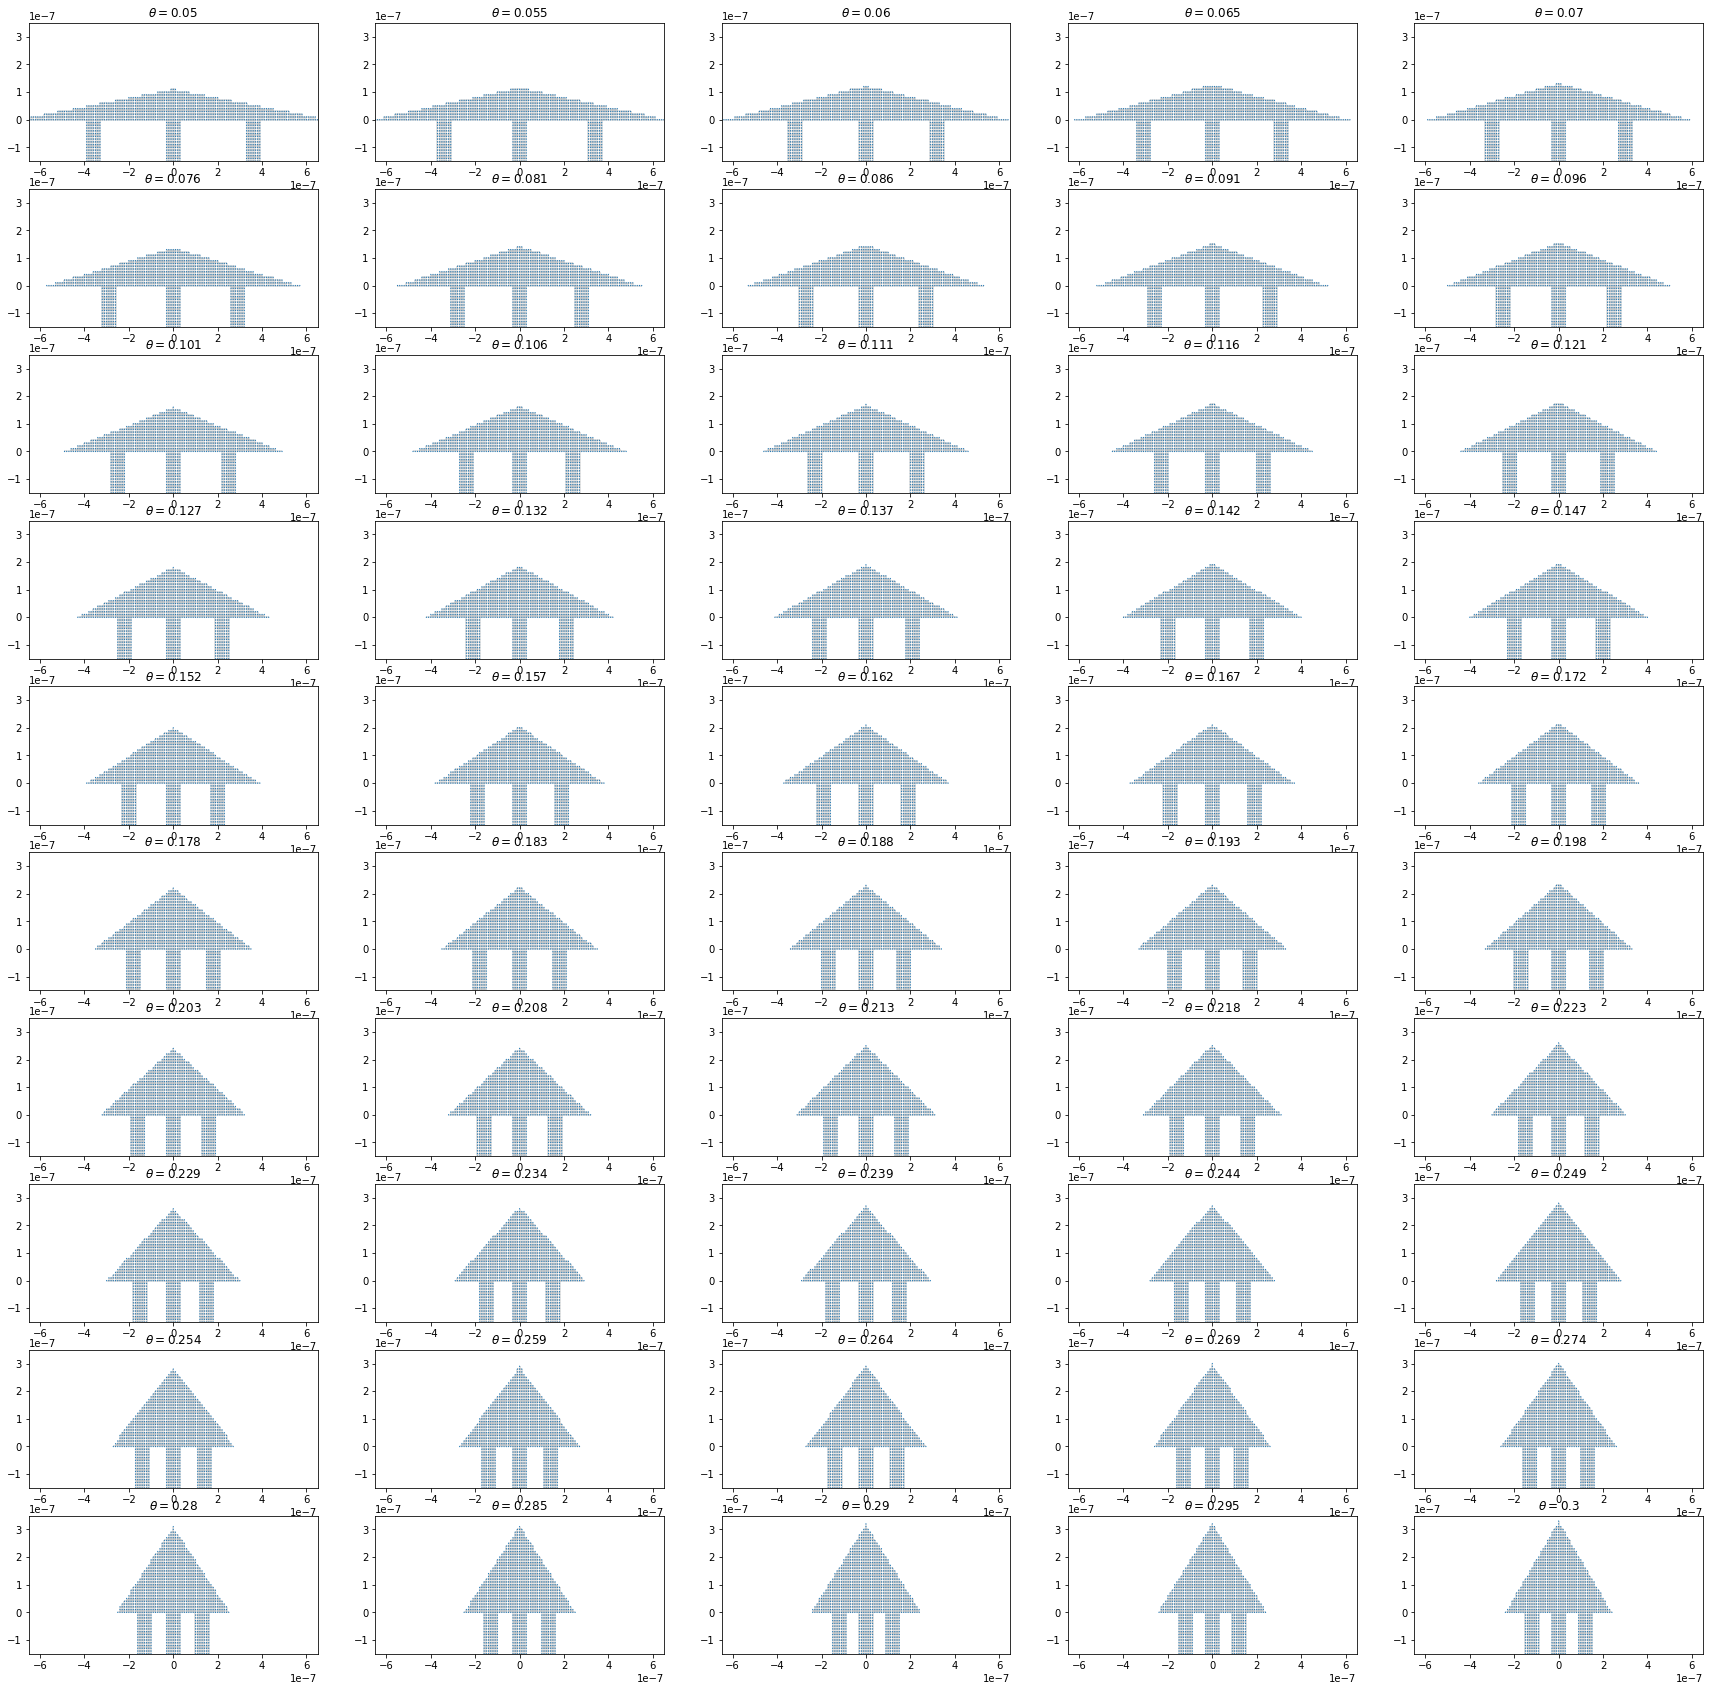

In [79]:
fig, ax = plt.subplots(ncols=int(n_geometries/10), nrows=10, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 3.5e-7)
    axes.set_xlim(-6.5e-7, 6.5e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [80]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [74]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript’: File exists
mkdir: cannot create directory ‘../data/manuscript/triangle_angles_one_side/’: File exists


256

In [ ]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product(range(n_geometries), mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/01e0b04819034312bcc5908d922e6839/status


## Analyse results

In [20]:
geometries = angles
geometry_parameter = r'$\theta[\pi]$'

In [21]:
n_peaks = 4
prominence = 1e-6
peaks_kwargs = {'prominence': 0, 'width': 3, 'height': 5e-6}

In [22]:
index = 0
# open raw simulation result
file = 'band_'+str(index)+'th.pickle'
with open(directory_path+file, 'rb') as data:
    result = pickle.load(data)

In [23]:
geometries_couplings = []
geometries_peaks = []
geometries_averages = []
geometries_widths = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, peaks = tl.coupling_data(data=geometry, sign=1, n_peaks=n_peaks, **peaks_kwargs)
    geometries_couplings.append(couplings)
    geometries_peaks.append(peaks)
    widths = []
    averaged_peaks = []
    for i in range(3):
        widths.append(np.mean((2e-2*peak_widths(x=couplings[i], peaks=peaks[i])[0])))
        averaged_peaks.append(np.mean(couplings[i][peaks[i]]))
    geometries_widths.append(widths)
    geometries_averages.append(averaged_peaks)

geometries_couplings = np.array(geometries_couplings)
geometries_peaks = np.array(geometries_peaks)
geometries_widths = np.array(geometries_widths)
geometries_averages = np.array(geometries_averages)

In [24]:
geometry = 0
pair = 0

couplings = 1e6*geometries_couplings[geometry][pair]
mus_qd_units = 1e3*mus_qd

In [25]:
title = r'$\theta$ = '
units = r'[$\pi$]'

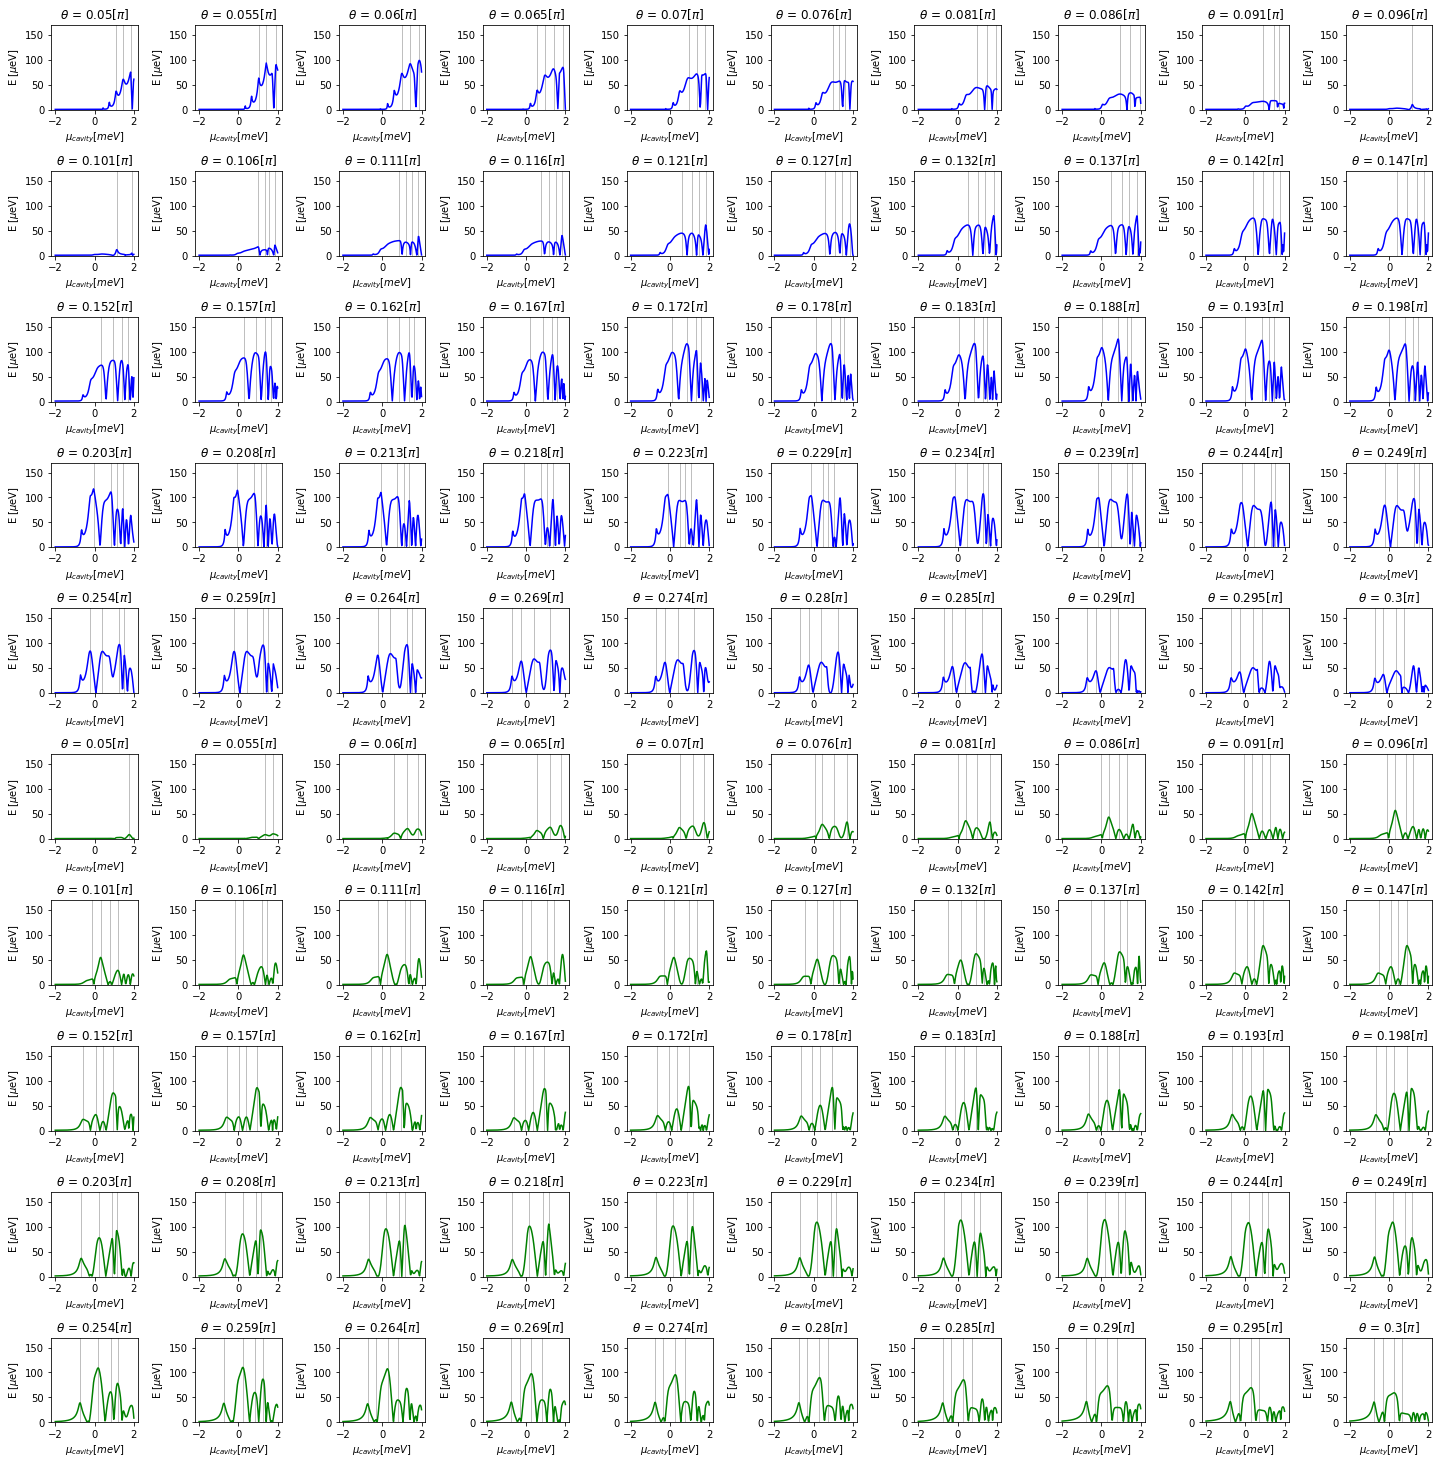

In [26]:
pt.plot_couplings(
    n_geometries,
    geometries,
    mus_qd_units,
    geometries_peaks,
    geometries_couplings,
    title,
    units,
    n_cols=10,
    n_rows=10,
    figsize=(20, 20)
)

In [27]:
averaged_widths = np.mean(geometries_widths.T, axis=0)
averaged_peaks = np.mean(geometries_averages.T, axis=0)

Text(0.5, 1.0, 'Triangular cavity wires one side: device rating')

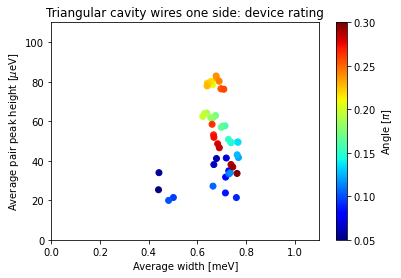

In [30]:
cmap = cm.get_cmap('jet')
pair = 1

fig, ax = plt.subplots()
plot = ax.scatter(2*averaged_widths, 1e6*averaged_peaks, c=angles, cmap=cmap)
ax.set_xlabel(r'Average width [meV]')
ax.set_ylabel(r'Average pair peak height [$\mu$eV]')
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 110)
cb = fig.colorbar(plot, ax=ax)
cb.set_label(r'Angle [$\pi$]')

ax.set_title(r'Triangular cavity wires one side: device rating')

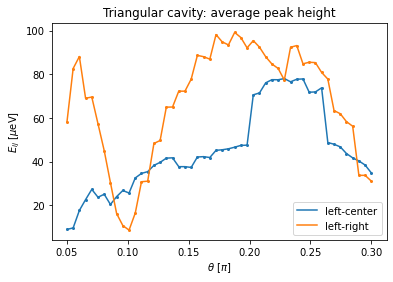

In [187]:
fig, ax = plt.subplots()

ax.plot(geometries, 1e6*geometries_averages.T[1], label='left-center')
ax.scatter(geometries, 1e6*geometries_averages.T[1], s=4)
ax.plot(geometries, 1e6*geometries_averages.T[0], label='left-right')
ax.scatter(geometries, 1e6*geometries_averages.T[0], s=4)

ax.set_ylabel(r'$E_{ij}$ [$\mu$eV]')
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_title(r'Triangular cavity: average peak height')

ax.legend()

# Triangular geometry with wires at both sides

## Set up parameters

In [4]:
area = 800*a**2
w = 7*a
geometry = {
    "l": 130*a,
    "w": w,
    "a": a,
    "side": 'up',
    "shape": 'triangle',
    "A": area
}

In [5]:
n_geometries = 50
angles = np.linspace(0.05, 0.3, n_geometries)

In [6]:
mus_qd = np.linspace(-0.002, 0.002, 200)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/triangle_angles_two_side/'

## Calculation

In [232]:
tjs = []
for theta in angles:
    geometry.update(angle=theta*np.pi)
    center = np.sqrt(np.abs(area/np.tan(theta*np.pi)))/2
    if center < 3*w/2:
        center = 10*a
    geometry.update(centers=[center, -center])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

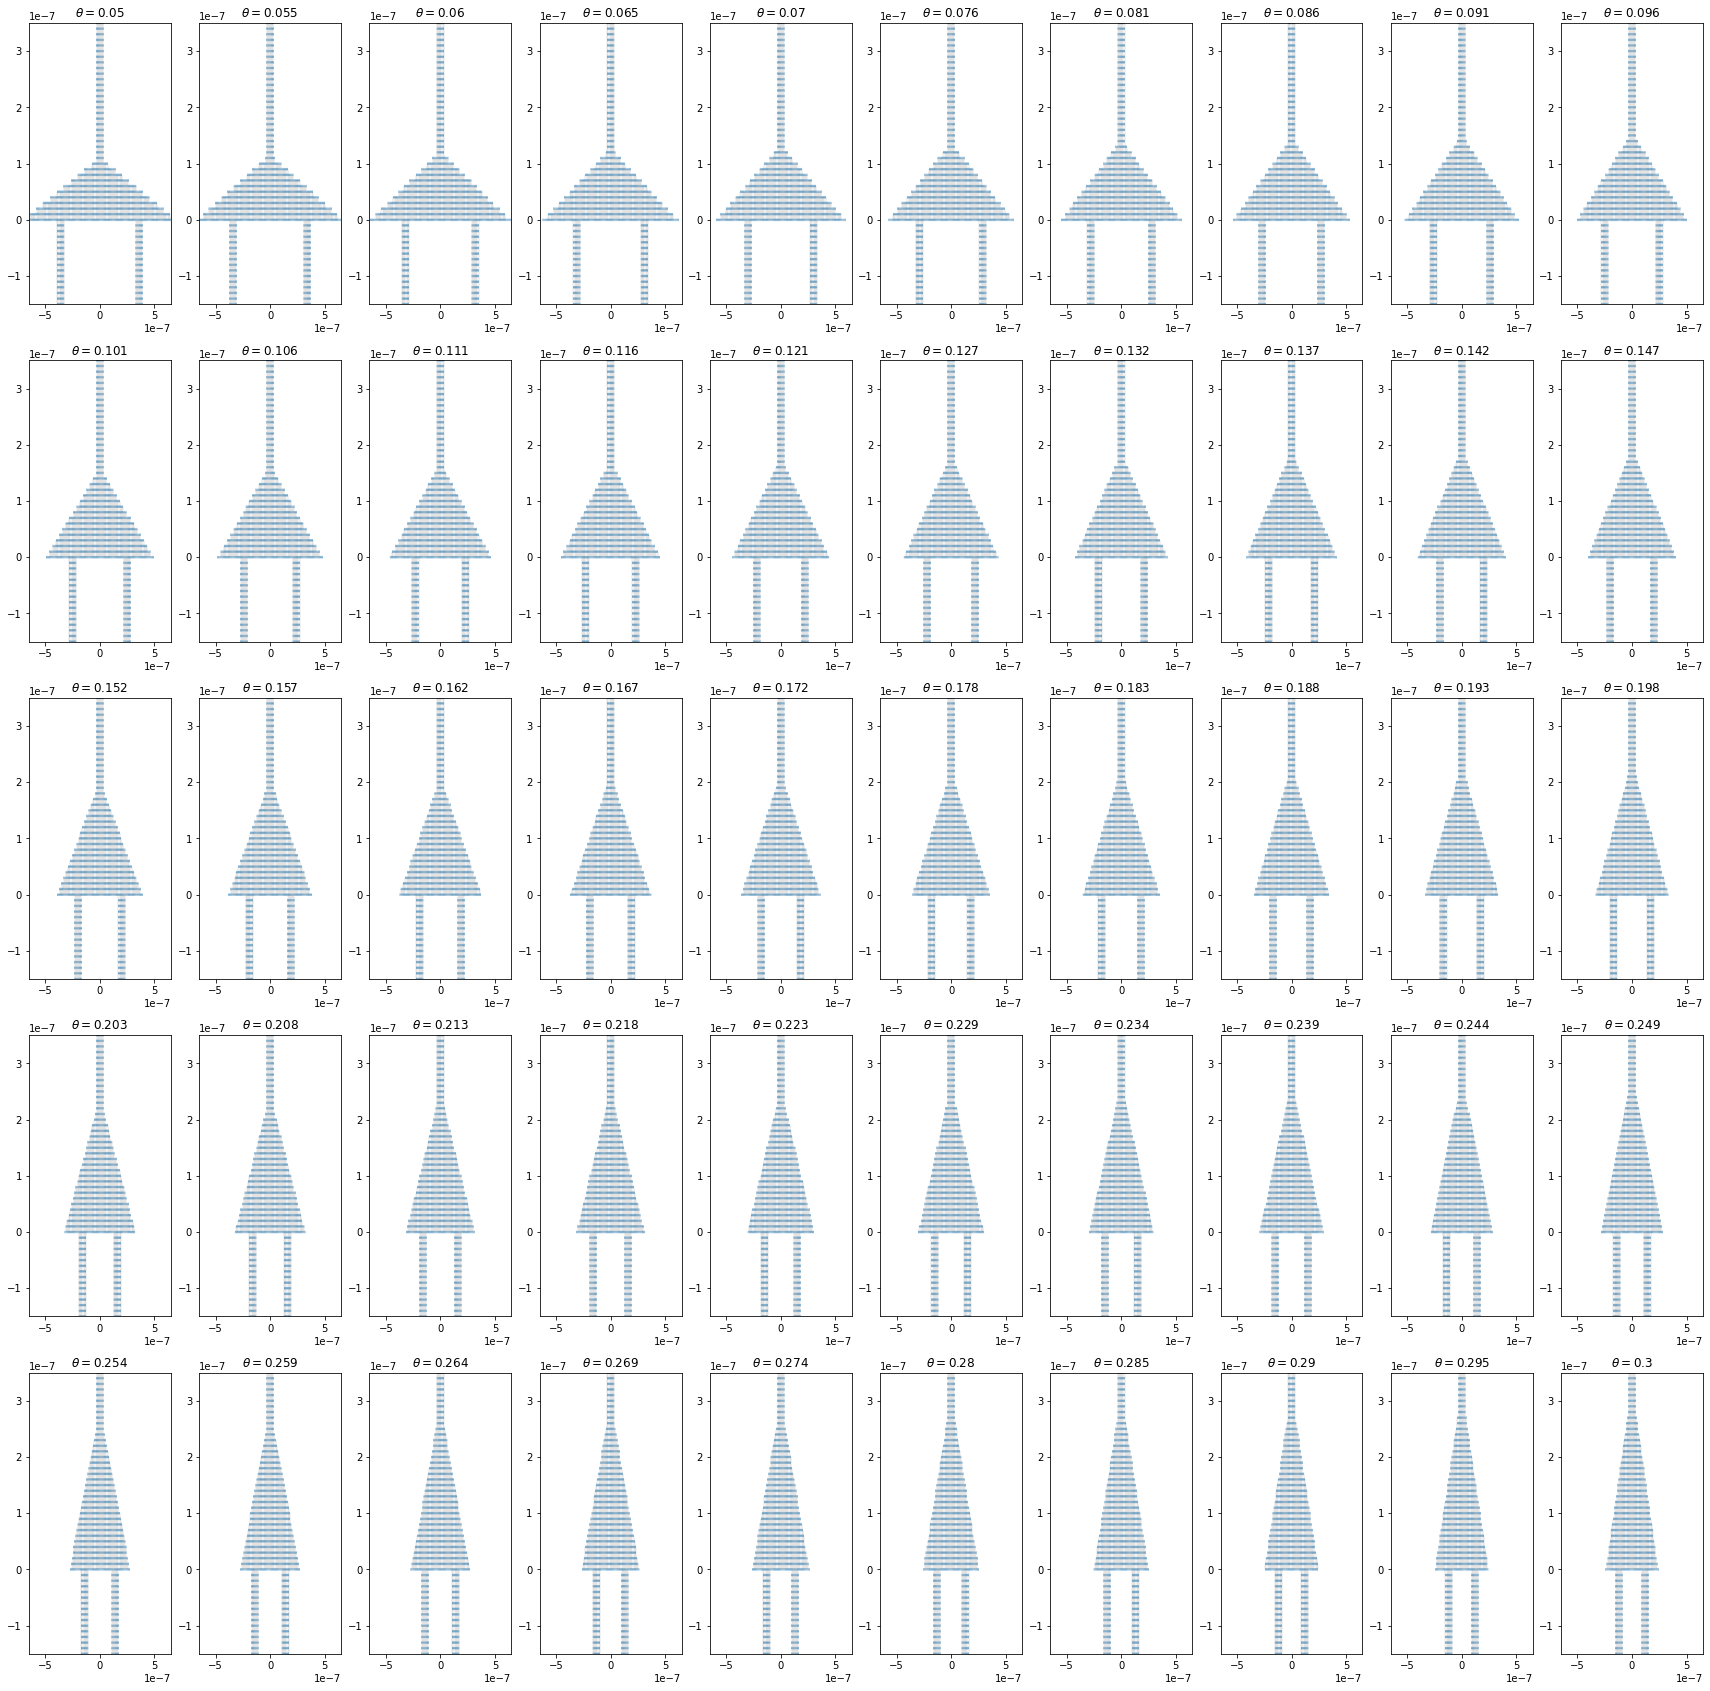

In [233]:
fig, ax = plt.subplots(ncols=int(n_geometries/5), nrows=5, figsize=(30, 30))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 3.5e-7)
    axes.set_xlim(-6.5e-7, 6.5e-7)
    axes.set_title(r'$\theta=$'+str(np.round(angles[i], 3)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [234]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [235]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/triangle_angles_two_side/’

256

: File exists


In [236]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product(range(n_geometries), mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/700656c2dad7414784d38d6f1e0fa302/status


## Analyse results

In [7]:
geometries = angles
geometry_parameter = r'$\theta[\pi]$'

In [8]:
n_peaks = 4
prominence = 1e-6
peaks_kwargs = {'prominence': 0, 'width': 3, 'height': 5e-6}

In [9]:
index = 0
# open raw simulation result
file = 'band_'+str(index)+'th.pickle'
with open(directory_path+file, 'rb') as data:
    result = pickle.load(data)

In [10]:
geometries_couplings = []
geometries_peaks = []
geometries_averages = []
geometries_widths = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, peaks = tl.coupling_data(data=geometry, sign=1, n_peaks=n_peaks, **peaks_kwargs)
    geometries_couplings.append(couplings)
    geometries_peaks.append(peaks)
    widths = []
    averaged_peaks = []
    for i in range(3):
        widths.append(np.mean((2e-2*peak_widths(x=couplings[i], peaks=peaks[i])[0])))
        averaged_peaks.append(np.mean(couplings[i][peaks[i]]))
    geometries_widths.append(widths)
    geometries_averages.append(averaged_peaks)

geometries_couplings = np.array(geometries_couplings)
geometries_peaks = np.array(geometries_peaks)
geometries_widths = np.array(geometries_widths)
geometries_averages = np.array(geometries_averages)

In [11]:
geometry = 0
pair = 0

couplings = 1e6*geometries_couplings[geometry][pair]
mus_qd_units = 1e3*mus_qd

In [12]:
title = r'$\theta$ = '
units = r'[$\pi$]'

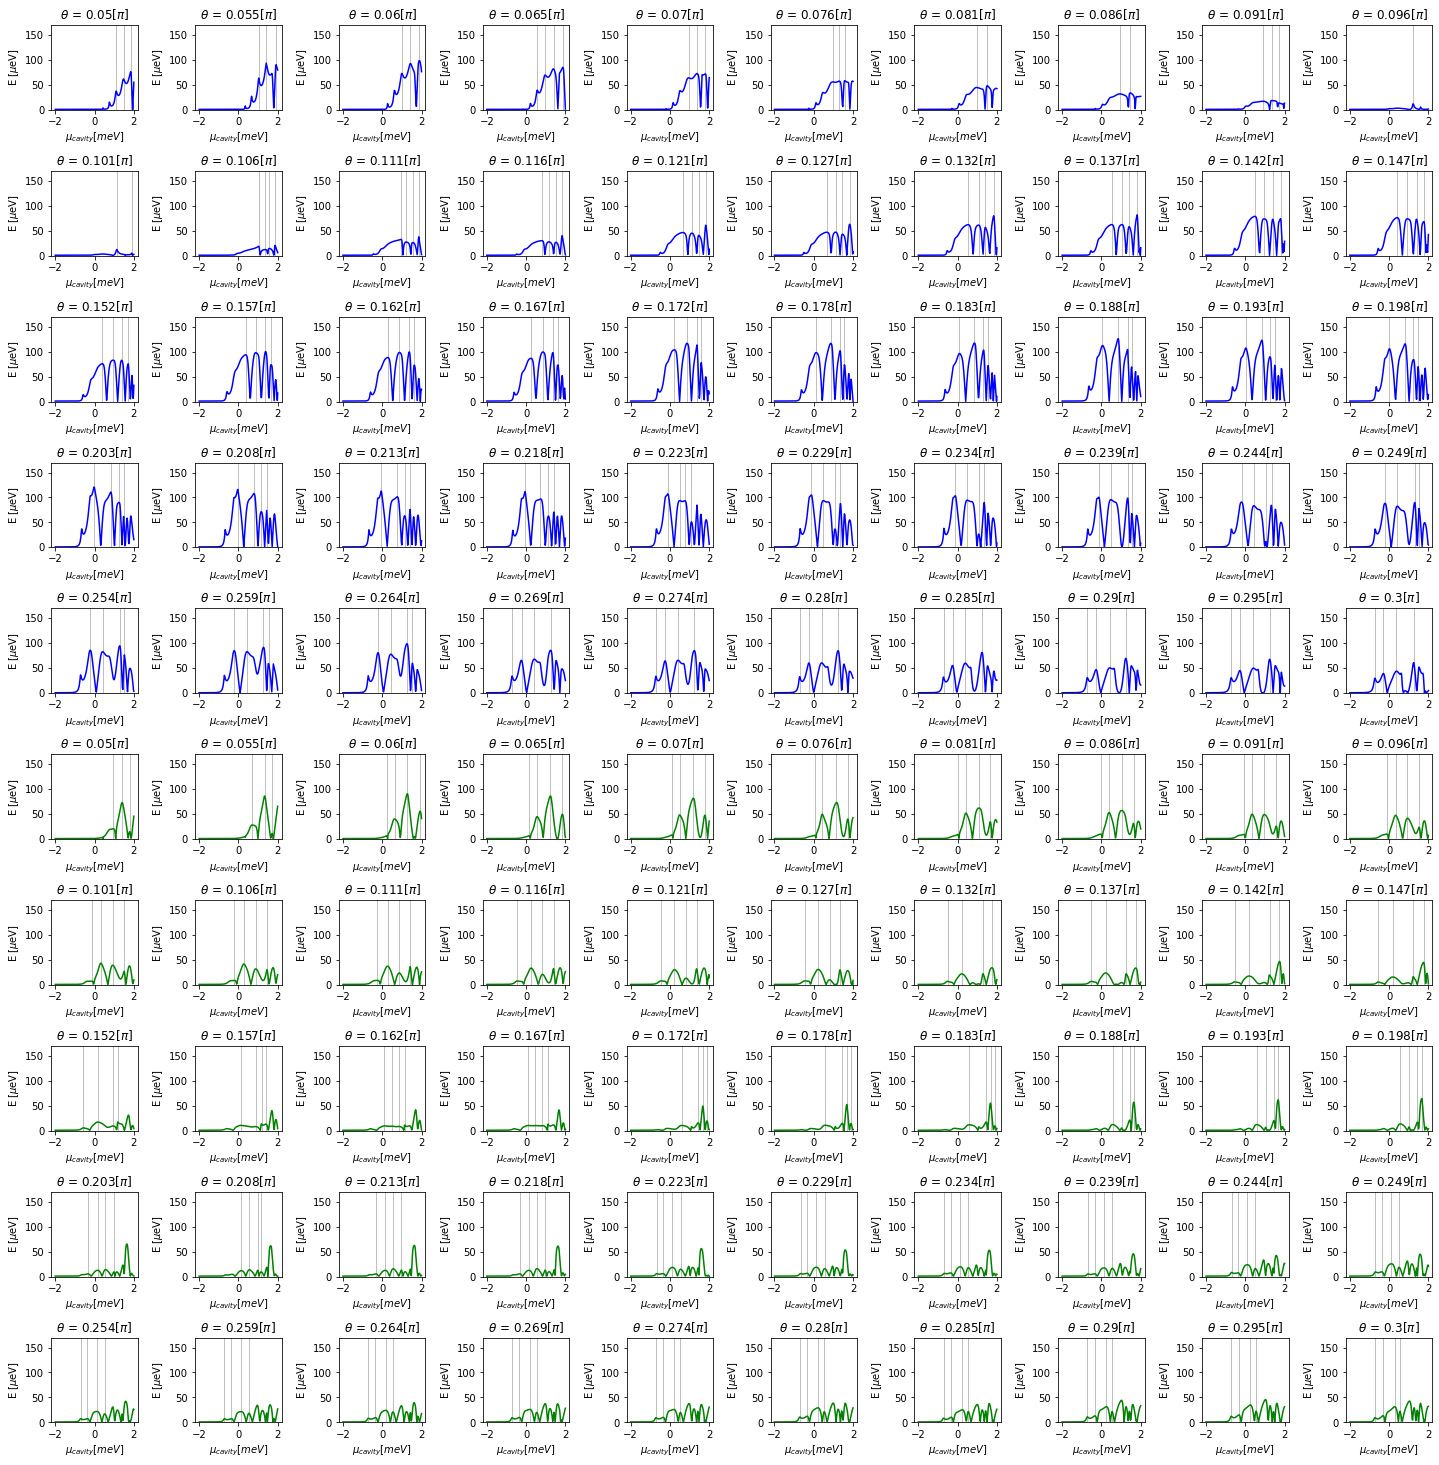

In [13]:
pt.plot_couplings(
    n_geometries,
    geometries,
    mus_qd_units,
    geometries_peaks,
    geometries_couplings,
    title,
    units,
    n_cols=10,
    n_rows=10,
    figsize=(20, 20)
)

In [14]:
averaged_widths = np.mean(geometries_widths.T, axis=0)
averaged_peaks = np.mean(geometries_averages.T, axis=0)

Text(0.5, 1.0, 'Triangular cavity wires both sides: device rating')

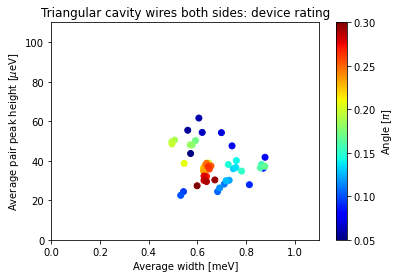

In [16]:
cmap = cm.get_cmap('jet')

fig, ax = plt.subplots()
plot = ax.scatter(2*averaged_widths, 1e6*averaged_peaks, c=angles, cmap=cmap)
ax.set_xlabel(r'Average width [meV]')
ax.set_ylabel(r'Average pair peak height [$\mu$eV]')
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 110)
cb = fig.colorbar(plot, ax=ax)
cb.set_label(r'Angle [$\pi$]')

ax.set_title(r'Triangular cavity wires both sides: device rating')

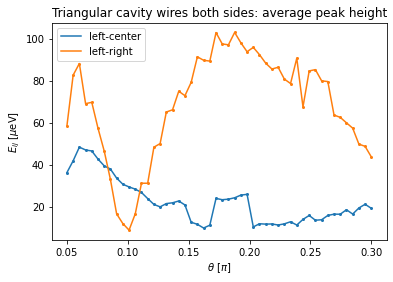

In [246]:
fig, ax = plt.subplots()

ax.plot(geometries, 1e6*geometries_averages.T[1], label='left-center')
ax.scatter(geometries, 1e6*geometries_averages.T[1], s=4)
ax.plot(geometries, 1e6*geometries_averages.T[0], label='left-right')
ax.scatter(geometries, 1e6*geometries_averages.T[0], s=4)

ax.set_ylabel(r'$E_{ij}$ [$\mu$eV]')
ax.set_xlabel(r'$\theta$ [$\pi$]')
ax.set_title(r'Triangular cavity wires both sides: average peak height')

ax.legend()

# Half ring cavity

In [295]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'ring',
}

In [296]:
n_geometries = 50
rads = np.linspace([6*a, 17*a], [91*a, 102*a], n_geometries)

In [297]:
mus_qd = np.linspace(-0.001, 0.003, 200)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/half_ring/'

## Calculation

In [84]:
tjs = []
for r, R in rads:
    geometry.update(r=r)
    geometry.update(R=R)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

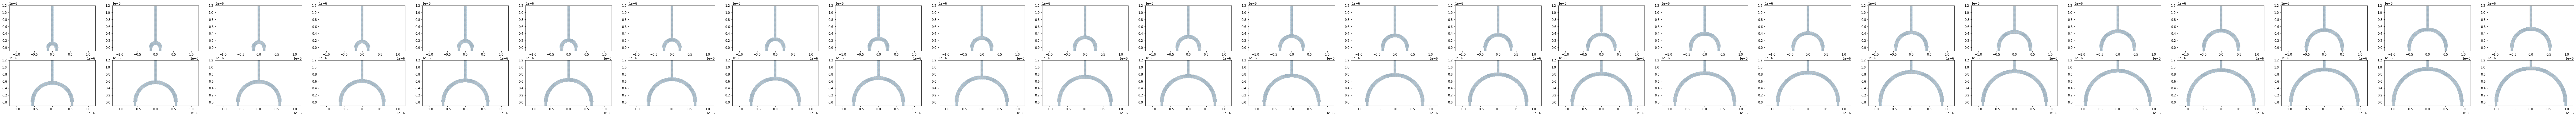

In [86]:
fig, ax = plt.subplots(ncols=int(n_geometries/2), nrows=2, figsize=(3*n_geometries, 6))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 12e-7)
    #axes.set_title(r'$d_{wires}=$'+str(int(distances[i]/a)))
    axes.set_xlim(-12e-7, 12e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [88]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [89]:
os.system('mkdir ' + directory_path)

0

In [90]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product(range(n_geometries), mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/42965aee7ab2432a89117e08b0b6a148/status


## Analysis

In [308]:
geometries = distances
geometry_parameter = r'$\theta[\pi]$'

In [341]:
n_peaks = 1
prominence = 10e-6
peaks_kwargs = {'prominence': prominence, 'width': 3, 'height': 0}

In [342]:
index = 0
# open raw simulation result
file = 'band_'+str(index)+'th.pickle'
with open(directory_path+file, 'rb') as data:
    result = pickle.load(data)

In [343]:
geometries_couplings = []
geometries_peaks = []
geometries_averages = []
geometries_widths = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, peaks = tl.coupling_data(data=geometry, sign=1, n_peaks=n_peaks, **peaks_kwargs)
    geometries_couplings.append(couplings)
    geometries_peaks.append(peaks)
    widths = []
    averaged_peaks = []
    for i in range(3):
        widths.append(np.mean((2e-2*peak_widths(x=couplings[i], peaks=peaks[i])[0])))
        averaged_peaks.append(np.mean(couplings[i][peaks[i]]))
    geometries_widths.append(widths)
    geometries_averages.append(averaged_peaks)

geometries_couplings = np.array(geometries_couplings)
geometries_peaks = np.array(geometries_peaks)
geometries_widths = np.array(geometries_widths)
geometries_averages = np.array(geometries_averages)

In [344]:
geometry = 0
pair = 0

couplings = 1e6*geometries_couplings[geometry][pair]
mus_qd_units = 1e3*mus_qd

In [345]:
title = r'$d_{wires}$ = '
units = r'[nm]'

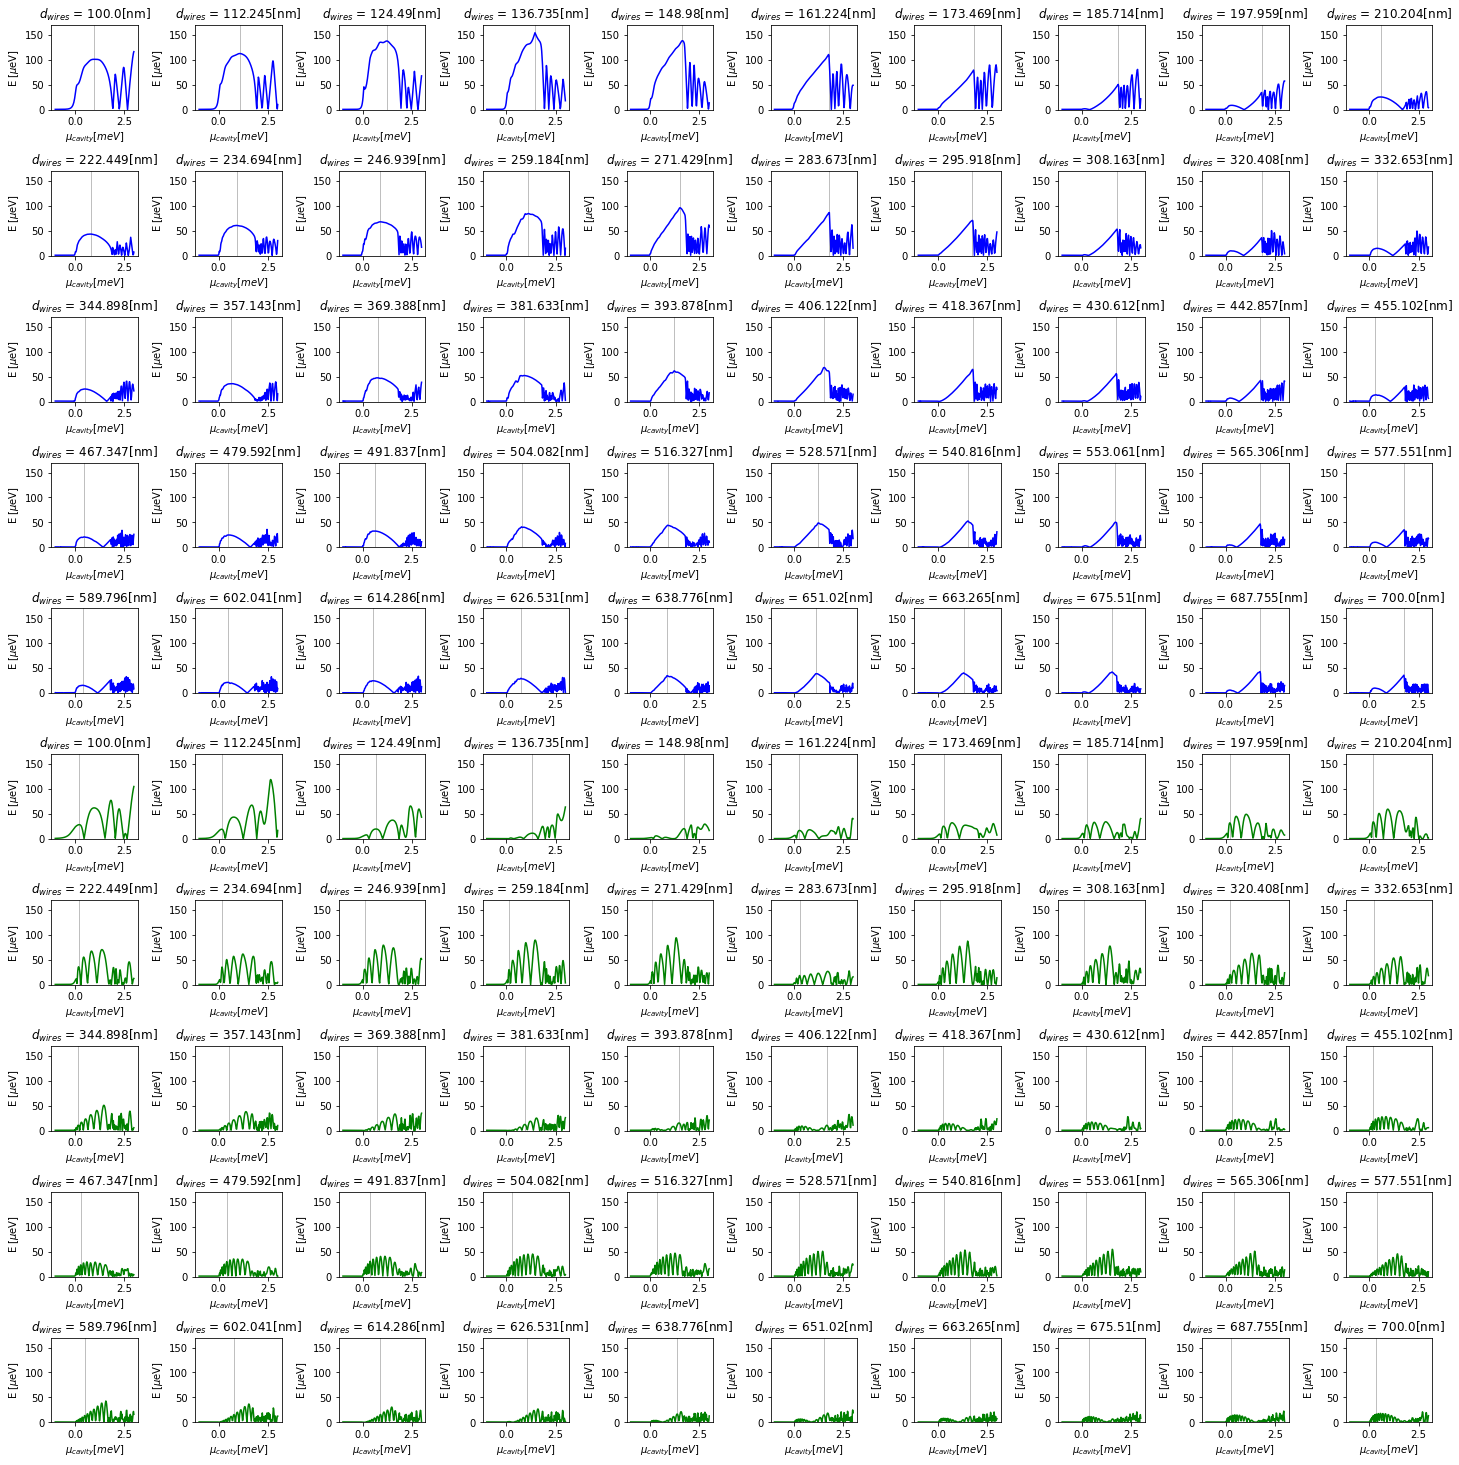

In [346]:
pt.plot_couplings(
    n_geometries,
    1e9*geometries,
    mus_qd_units,
    geometries_peaks,
    geometries_couplings,
    title,
    units,
    n_cols=10,
    n_rows=10,
    figsize=(20, 20)
)

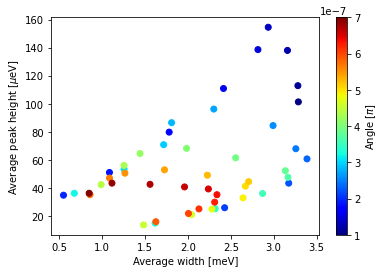

In [347]:
cmap = cm.get_cmap('jet')
pair = 0

fig, ax = plt.subplots()
plot = ax.scatter(2*geometries_widths.T[pair], 1e6*geometries_averages.T[pair], c=distances, cmap=cmap)
ax.set_xlabel(r'Average width [meV]')
ax.set_ylabel(r'Average peak height [$\mu$eV]')
#ax.set_xlim(0, 1.1)
#ax.set_ylim(0, 110)
cb = fig.colorbar(plot, ax=ax)
cb.set_label(r'Angle [$\pi$]')

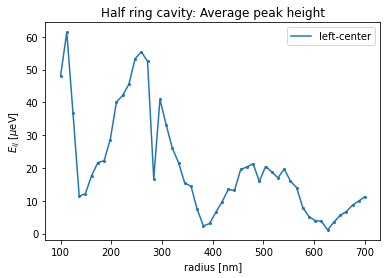

In [326]:
fig, ax = plt.subplots()

ax.plot(1e9*geometries, 1e6*geometries_averages.T[1], label='left-center')
ax.scatter(1e9*geometries, 1e6*geometries_averages.T[1], s=4)
#ax.plot(1e9*geometries, 1e6*geometries_averages.T[0], label='left-right')
#ax.scatter(1e9*geometries, 1e6*geometries_averages.T[0], s=4)

ax.set_ylabel(r'$E_{ij}$ [$\mu$eV]')
ax.set_xlabel(r'radius [nm]')
ax.set_title(r'Half ring cavity: Average peak height')

ax.legend()

# Rectangular cavity

In [201]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 154*a
}

In [202]:
n_geometries = 50
distances = np.linspace(10*a, 70*a, n_geometries)

In [203]:
mus_qd = np.linspace(-0.002, 0.002, 200)
key = 'mu_qd'
n = 6
directory_path = '../data/manuscript/rectangle_wires/'

## Calculation

In [32]:
tjs = []
for distance in distances:
    geometry.update(centers=[distance, -distance])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

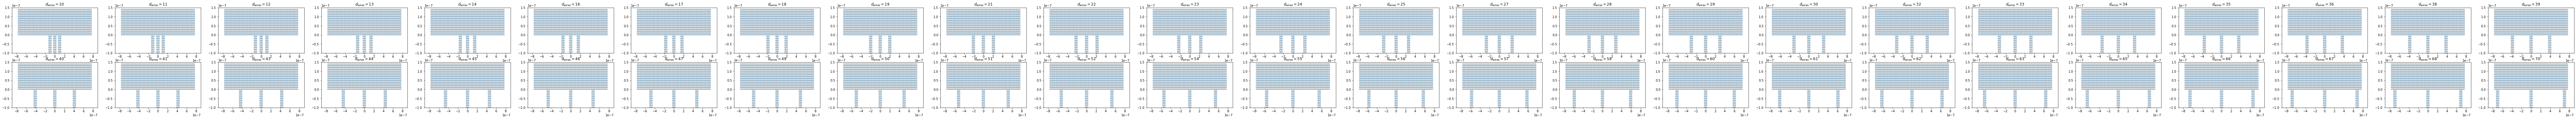

In [36]:
fig, ax = plt.subplots(ncols=int(n_geometries/2), nrows=2, figsize=(3*n_geometries, 6))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 1.5e-7)
    axes.set_title(r'$d_{wires}=$'+str(int(distances[i]/a)))
    axes.set_xlim(-9e-7, 9e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [37]:
eigen = sl.solver(geometries=tjs, n=n, key=key)

def wrap(args):
    return eigen(*args)

In [12]:
os.system('mkdir ' + directory_path)

mkdir: cannot create directory ‘../data/manuscript/rectangle_wires/’: File exists


256

In [38]:
# execute calculation
index = 0
params = sl.finite_coupling_parameters(index=index)

args = list(it.product(range(n_geometries), mus_qd, params))
args_db = db.from_sequence(args, npartitions=40)

with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/band_'+str(index)+'th.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/7ac3b493f5f742098a3c92d5ab0f9726/status


## Analysis

In [204]:
geometries = distances
geometry_parameter = r'$d_{wires}$'

In [205]:
n_peaks = 3
prominence = 0
peaks_kwargs = {'prominence': 1e-6, 'width': 3, 'height': 0}

In [206]:
index = 0
# open raw simulation result
file = 'band_'+str(index)+'th.pickle'
with open(directory_path+file, 'rb') as data:
    result = pickle.load(data)

In [207]:
geometries_couplings = []
geometries_peaks = []
geometries_averages = []
geometries_widths = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, peaks = tl.coupling_data(data=geometry, sign=1, n_peaks=n_peaks, **peaks_kwargs)
    geometries_couplings.append(couplings)
    geometries_peaks.append(peaks)
    widths = []
    averaged_peaks = []
    for i in range(3):
        widths.append(np.mean((2e-2*peak_widths(x=couplings[i], peaks=peaks[i])[0])))
        averaged_peaks.append(np.mean(couplings[i][peaks[i]]))
    geometries_widths.append(widths)
    geometries_averages.append(averaged_peaks)

geometries_couplings = np.array(geometries_couplings)
geometries_peaks = np.array(geometries_peaks)
geometries_widths = np.array(geometries_widths)
geometries_averages = np.array(geometries_averages)

In [208]:
geometry = 0
pair = 0

couplings = 1e6*geometries_couplings[geometry][pair]
mus_qd_units = 1e3*mus_qd

In [209]:
title = r'$d_{wires}$ = '
units = r'[nm]'

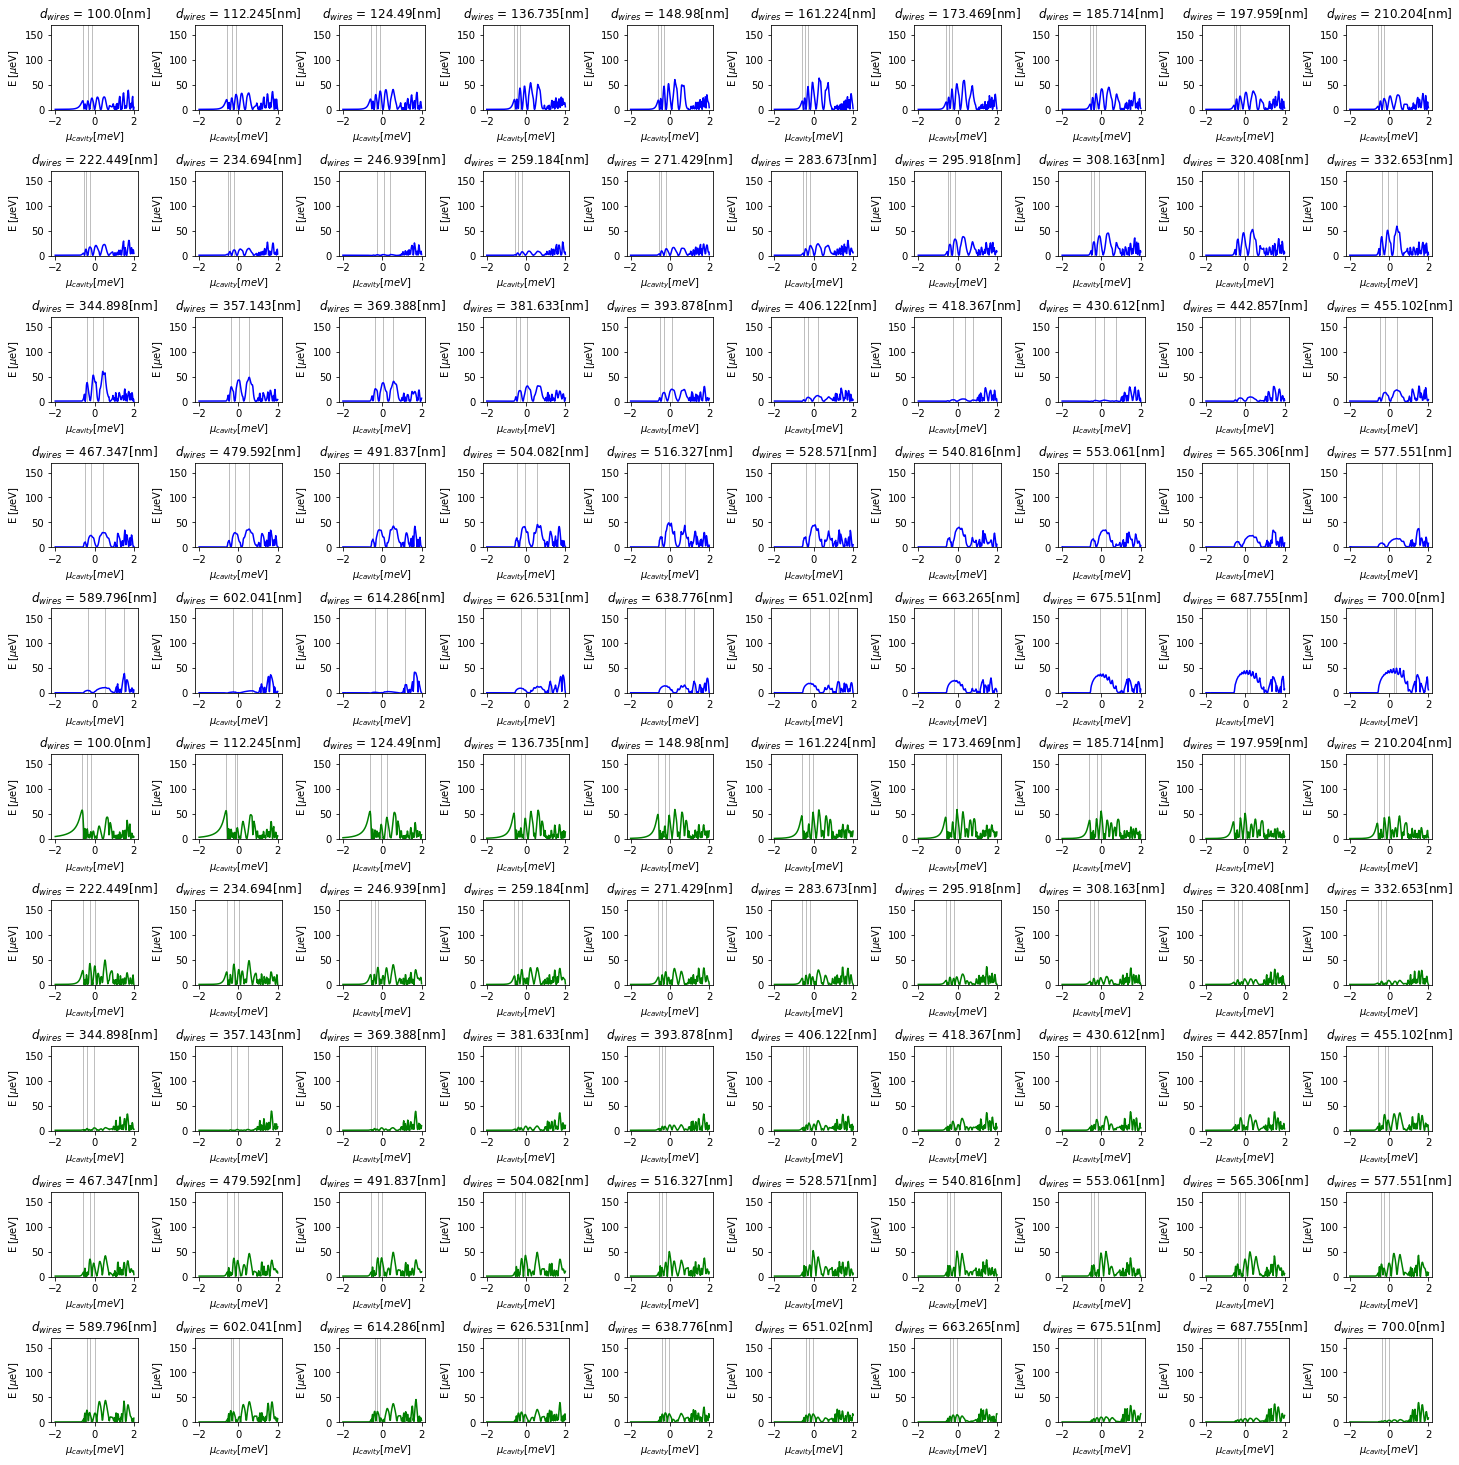

In [210]:
pt.plot_couplings(
    n_geometries,
    1e9*geometries,
    mus_qd_units,
    geometries_peaks,
    geometries_couplings,
    title,
    units,
    n_cols=10,
    n_rows=10,
    figsize=(20, 20)
)

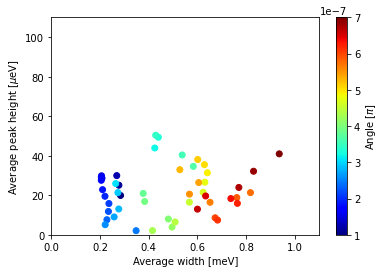

In [211]:
cmap = cm.get_cmap('jet')
pair = 0

fig, ax = plt.subplots()
plot = ax.scatter(2*geometries_widths.T[pair], 1e6*geometries_averages.T[pair], c=distances, cmap=cmap)
ax.set_xlabel(r'Average width [meV]')
ax.set_ylabel(r'Average peak height [$\mu$eV]')
ax.set_xlim(0, 1.1)
ax.set_ylim(0, 110)
cb = fig.colorbar(plot, ax=ax)
cb.set_label(r'Angle [$\pi$]')

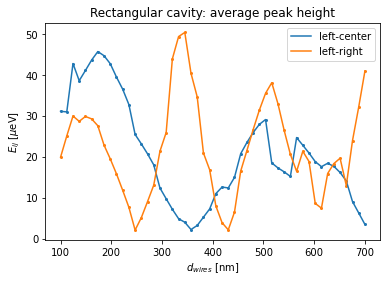

In [213]:
fig, ax = plt.subplots()

ax.plot(1e9*geometries, 1e6*geometries_averages.T[1], label='left-center')
ax.scatter(1e9*geometries, 1e6*geometries_averages.T[1], s=4)
ax.plot(1e9*geometries, 1e6*geometries_averages.T[0], label='left-right')
ax.scatter(1e9*geometries, 1e6*geometries_averages.T[0], s=4)

ax.set_ylabel(r'$E_{ij}$ [$\mu$eV]')
ax.set_xlabel(r'$d_{wires}$ [nm]')
ax.set_title(r'Rectangular cavity: average peak height')

ax.legend()

# Circular cavity

In [218]:
angle = 0.7
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'y',
    "angle": angle,
    "radius": 30*a,
    "w_v": 11*a
}

In [219]:
n_geometries = 10
radius = np.linspace(10, 30, n_geometries)
areas = np.linspace(180, 800, n_geometries)

In [220]:
tjs = []
for i in range(n_geometries):
    geometry.update(radius=radius[i]*a)
    geometry.update(A=areas[i]*a**2)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

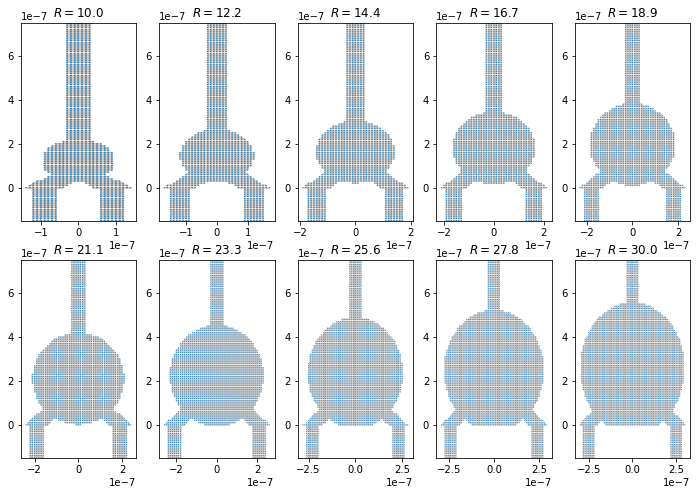

In [221]:
fig, ax = plt.subplots(ncols=int(n_geometries/2), nrows=2, figsize=(12, 8))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1.5e-7, 7.5e-7)
    #axes.set_xlim(-6.5e-7, 6.5e-7)
    axes.set_title(r'$R=$'+str(np.round(radius[i], 1)))
    #axes.set_xlim(-5e-7, 5e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1